<Axes: >

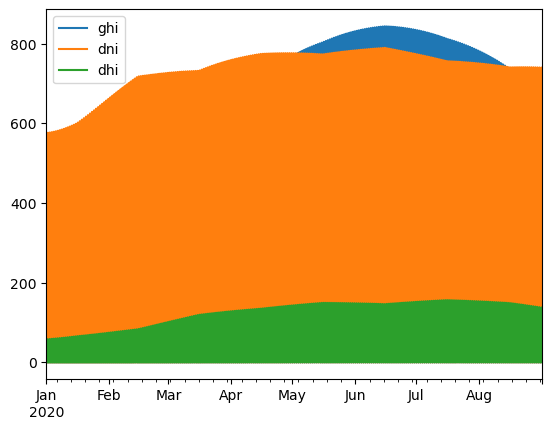

In [29]:
#We're going to add a clear sky function which will receive a dataframe and then returns a dataframe where the  csi is added with option to remove
import pvlib
import pandas as pd
from pvlib.pvsystem import PVSystem, FixedMount

from pvlib.modelchain import ModelChain

from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

import matplotlib.pyplot as plt
from pvlib.location import Location

from pvlib.iotools import read_tmy3

latitude = 50.994716
longitude = 5.539433
tz = 'UTC'
peak_power = 2400
location = Location(latitude, longitude, tz= tz)
start = pd.to_datetime("2020-01-01:00-00-00", format='%Y-%m-%d:%H-%M-%S')
end = pd.to_datetime("2020-08-31:23-00-00", format='%Y-%m-%d:%H-%M-%S')
freq = '1h'

#1. Get clear sky irradiance for location
times = pd.date_range(start=start, end=end, freq=freq, tz=tz)
cs = location.get_clearsky(times)

cs.plot()

In [35]:
# Substitute solution: make clear sky power just multiple of irradiance
module_parameters = {'pdc0': 5000, 'gamma_pdc': -0.004}
inverter_parameters = {'pdc0': 5000, 'eta_inv_nom': 0.96}
system = PVSystem(module_parameters=module_parameters,
                           inverter_parameters=inverter_parameters)
system

PVSystem:
  name: None
  Array:
    name: None
    mount: FixedMount(surface_tilt=0, surface_azimuth=180, racking_model=None, module_height=None)
    module: None
    albedo: 0.25
    module_type: None
    temperature_model_parameters: {}
    strings: 1
    modules_per_string: 1
  inverter: None

In [2]:
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# load some module and inverter specifications
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [3]:
N = round(peak_power/250)
N

10

In [30]:
# Initialize PV system

system = PVSystem(surface_tilt=20, surface_azimuth=200,
                  module_parameters=sandia_module,
                  modules_per_string=N,
                  inverter_parameters=cec_inverter,
                  temperature_model_parameters=temperature_model_parameters)



mc = ModelChain(system, location)
print(mc)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


In [31]:
mc.results.dc

<Axes: >

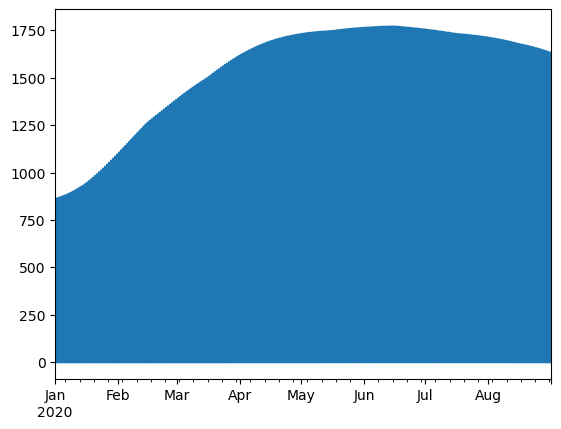

In [45]:
#Run for CSI as irradiance
mc.run_model(cs)
csi_power = mc.results.dc["p_mp"]
csi_power.plot()

In [46]:
csi_power = pd.DataFrame(csi_power)
csi_power.head()

,p_mp
2020-01-01 00:00:00+00:00,0.0
2020-01-01 01:00:00+00:00,0.0
2020-01-01 02:00:00+00:00,0.0
2020-01-01 03:00:00+00:00,0.0
2020-01-01 04:00:00+00:00,0.0


In [43]:
pvgis = pd.read_pickle("Data/PVGIS.pickle")
print(pvgis)


pv_power = pvgis.xs('P', axis=1)
pv_power = pv_power['2020-01-01': '2020-08-31']
pv_power = pd.DataFrame(pv_power)
pv_power.head()

                       P  Gb(i)  Gd(i)  Gr(i)  H_sun   T2m  WS10m  Int
time                                                                  
2005-01-01 00:00:00  0.0    0.0    0.0    0.0    0.0  7.61   2.41    0
2005-01-01 01:00:00  0.0    0.0    0.0    0.0    0.0  7.01   2.28    0
2005-01-01 02:00:00  0.0    0.0    0.0    0.0    0.0  6.43   2.28    0
2005-01-01 03:00:00  0.0    0.0    0.0    0.0    0.0  5.82   2.00    0
2005-01-01 04:00:00  0.0    0.0    0.0    0.0    0.0  5.44   1.45    0
...                  ...    ...    ...    ...    ...   ...    ...  ...
2020-12-31 19:00:00  0.0    0.0    0.0    0.0    0.0  2.20   1.72    0
2020-12-31 20:00:00  0.0    0.0    0.0    0.0    0.0  2.12   1.72    0
2020-12-31 21:00:00  0.0    0.0    0.0    0.0    0.0  2.01   1.72    0
2020-12-31 22:00:00  0.0    0.0    0.0    0.0    0.0  1.97   1.79    0
2020-12-31 23:00:00  0.0    0.0    0.0    0.0    0.0  1.94   1.86    0

[140256 rows x 8 columns]


,P
time,
2020-01-01 00:00:00,0.0
2020-01-01 01:00:00,0.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.0


In [38]:
test.divis.idxmax()

date = pd.to_datetime('2020-08-19 18:00:00+0000', utc=True)
test.loc[date]

p_mp      56.813775
P          0.000000
substr     0.023672
divis      0.000000
Name: 2020-08-19 18:00:00+00:00, dtype: float64

In [47]:
test = pd.merge(csi_power, pv_power, left_index = True, right_index = True)
test['substr'] = (test["p_mp"]-test["P"])/peak_power
test['divis'] = test["P"]/test["p_mp"]
test.fillna(0, inplace=True)
plt.figure()
test.P.plot()
plt.figure()
test.p_mp.plot()
plt.figure()
test.substr.plot()
plt.figure()
test.divis.plot()


TypeError: Cannot join tz-naive with tz-aware DatetimeIndex

In [39]:
#plot difference between clear sky and actual
from util import daytime
pv_power,_,_ = daytime.remove_nighttime([pv_power], 'P')
csi_power,_,_ = daytime.remove_nighttime([csi_power], 'p_mp')

